In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Datum shape for input and output is (timesteps, neurons): torch.Size([10, 15])


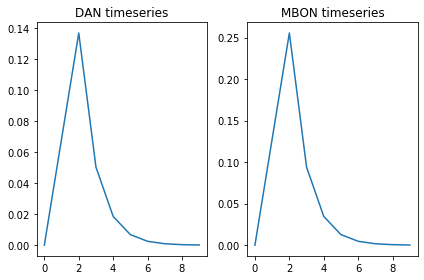

In [66]:
dataset = MushroomBodyDataset()

print(f'Datum shape for input and output is (timesteps, neurons): {dataset[0]["dan"].shape}')

fig, axs = plt.subplots(1,2)
axs[0].plot(dataset[0]["dan"][:,0])
axs[0].set_title('DAN timeseries')
axs[1].plot(dataset[0]["mbon"][:,0])
axs[1].set_title('MBON timeseries')
plt.tight_layout()
plt.show()

In [67]:
num_samples = len(dataset.data)
train_percentage, val_percentage = 0.6, 0.2
test_percentage = 1 - train_percentage - val_percentage

lengths = [
    int(train_percentage * num_samples), 
    int(val_percentage * num_samples),
    int(test_percentage * num_samples),
]

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))

print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 5400
Val dataset size: 1800
Test dataset size: 1800


# Hyperparams

In [68]:
hparams = {
    'batch_size': 8,
    'lr': 0.00005,
    'non_linearity': 'tanh',
    'max_epochs': 20,
    'min_epochs': 1
}

# Create Dataloaders

In [69]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Instantiate Model

In [70]:
model = NeuralRNNModule(
    masked=False,                          # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_dim=15,                          # input dim
    hidden_dim=15,                         # hidden dim
    non_linearity=hparams['non_linearity'] # relu or tanh
)

model.hparams

"lr":            5e-05
"masked":        False
"non_linearity": tanh

In [71]:
# Check that the forward pass does what I expect
batch = next(iter(train_dataloader))
output = model(batch['dan'])
output.shape    # (batch, sequnce length, nodes)

torch.Size([8, 10, 15])

### Check the Weight initialisation:

In [72]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8], switch=False):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)


    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    if switch:
        plt.xlabel('Target')
        plt.ylabel('Source')
    else:
        plt.xlabel('Source')
        plt.ylabel('Target')
        
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom")

    plt.tight_layout()
    plt.show()

greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

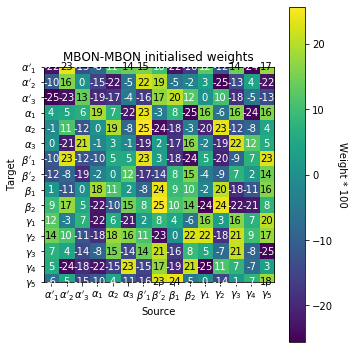

In [73]:
M = model.rnn.W_hh.weight.detach().numpy() * 100
plot_matrix(
    M, 
    greek_lobes, 
    'MBON-MBON initialised weights', 
    'Weight * 100',
    switch=False,
    size=[5,5]
)

# Train Model

In [74]:
logger = TensorBoardLogger("tb_logs", name="rnn", default_hp_metric=False)

In [75]:
logger.log_hyperparams(hparams)

In [76]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
#     callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [77]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name     | Type      | Params
---------------------------------------
0 | rnn      | NeuralRNN | 480   
1 | loss_fcn | MSELoss   | 0     
---------------------------------------
480       Trainable params
0         Non-trainable params
480       Total params
0.002     Total estimated model params size (MB)


Epoch 0:  75%|███████▌  | 675/900 [00:13<00:04, 49.62it/s, loss=0.0351, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████▌  | 675/900 [00:16<00:05, 40.23it/s, loss=0.0189, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 2:  75%|███████▌  | 675/900 [00:16<00:05, 39.83it/s, loss=0.0118, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 3:  75%|███████▌  | 675/900 [00:15<00:05, 44.08it/s, loss=0.0079, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  75%|███████▌  | 676/900 [00:13<00:04, 51.52it/s, loss=0.00553, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 5:  75%|███████▌  | 676/900 [00:16<00:05, 39.88it/s, loss=0.00411, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 6:  75%|███████▌  | 676/900 [00:10<00:03, 62.28it/s, loss=0.00325, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 7:  75%|███████▌  | 676/900 [00:11<00:03, 59.48it/s, loss=0.00273, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 8:  75%|███████▌  | 676/900 [00:12<00:04, 55.74it/s, loss=0.0024, v_num=3] 
Validating: 0it [

# Load Connectomics (for comparison)

In [21]:
mbon2mbon_connectome = np.load('../data/mbon-connectomics.npy')

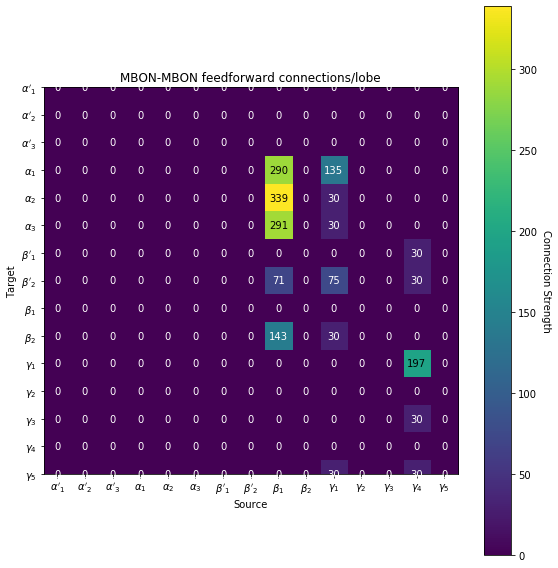

In [22]:
plot_matrix(
    mbon2mbon_connectome, 
    greek_lobes, 
    'MBON-MBON feedforward connections/lobe', 
    'Connection Strength'
)

# Visualise the trained weights

In [23]:
def normalise(m):
    if m.min() < 0:
        return (m - m.min() )/ (m.max() - m.min())
    
    return m / m.max()

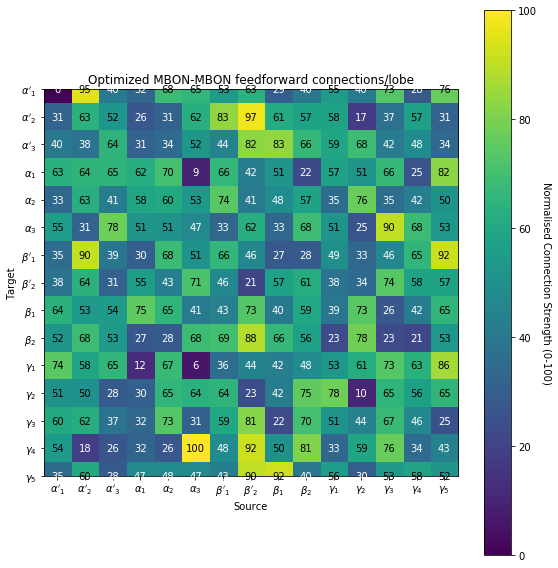

In [78]:
# multiply by 100 for visulisation purposes
M = normalise(model.rnn.W_hh.weight.detach().numpy()) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Optimized MBON-MBON feedforward connections/lobe', 
    'Normalised Connection Strength (0-100)'
)

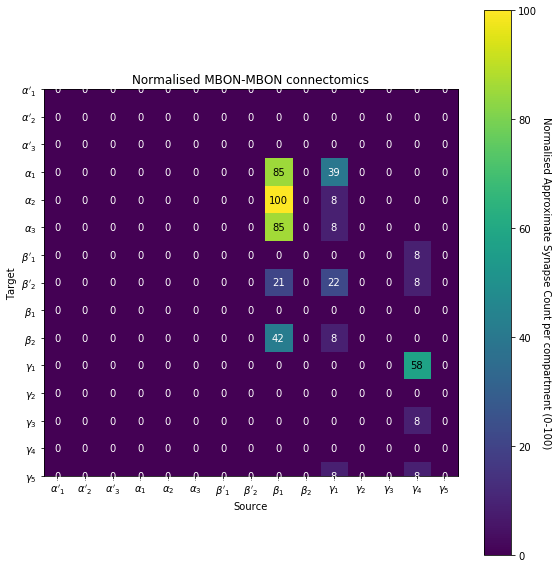

In [72]:
# multiply by 100 for visulisation purposes
M = normalise(mbon2mbon_connectome) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Normalised MBON-MBON connectomics', 
    'Normalised Approximate Synapse Count per compartment (0-100)'
)

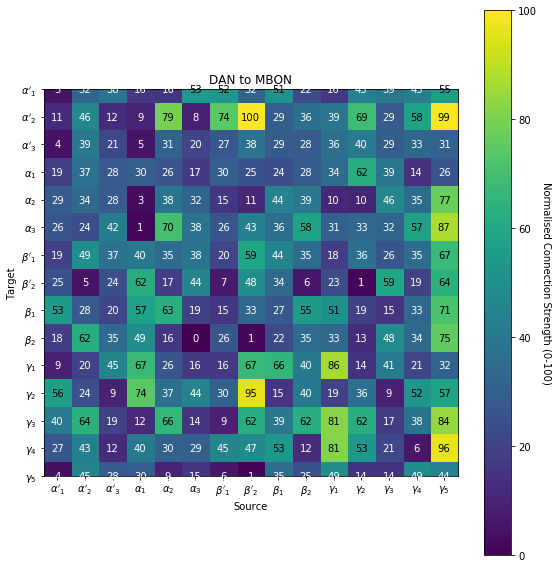

In [79]:
M = normalise(model.rnn.W_xh.weight.detach().numpy()) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'DAN to MBON', 
    'Normalised Connection Strength (0-100)'
)

# Further Testing and Evaluation

In [80]:
 model.eval()

NeuralRNNModule(
  (rnn): NeuralRNN(
    (W_xh): Linear(in_features=15, out_features=15, bias=True)
    (W_hh): Linear(in_features=15, out_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

In [81]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

In [82]:
loss_fcn = nn.MSELoss()
loss = 0
for x in test_dataloader:
    y_pred = model(x['dan']) 
    y = x['mbon']
    loss += loss_fcn(y, y_pred)


In [83]:
mse_loss = loss/len(test_dataset)
print(mse_loss)

tensor(0.0017, grad_fn=<DivBackward0>)


In [84]:
batch = next(iter(test_dataloader))
output = model(batch['dan'])

print(output.shape)

torch.Size([1, 10, 15])


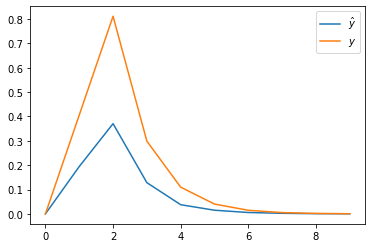

In [89]:
compartment = 1
plt.plot(output[0,:,compartment].detach().numpy(), label=r'$\hat y$')
plt.plot(batch['mbon'][0,:,compartment], label=r'$y$')

plt.legend()
plt.show()